In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
print(device_name)

if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
/device:GPU:0
Found GPU at: /device:GPU:0


# Import Library

In [1]:
#tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras import Sequential
from keras.layers.pooling import AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.convolutional import Convolution2D
from tensorflow.keras.layers import Flatten, Dense,BatchNormalization,Dropout,Input, ZeroPadding2D
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential, Model
import keras.backend as K
from sklearn.metrics import log_loss
# Utils
import os
import cv2
from sklearn.utils import shuffle
from pathlib import Path
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import time

# #mount drive
from google.colab import drive
drive.mount("/content/drive")

#Evaluation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score


# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns;
from glob import glob
import random



Mounted at /content/drive


# Image Augmentation

In [2]:
def img_Generator(file_name,gen_type,size):
    if gen_type=='yes':
        generet_Data=ImageDataGenerator(rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')
        gen_data=generet_Data.flow_from_directory(file_name,target_size=(size, size),
                                                  batch_size=32,shuffle=True,
                                                  class_mode='categorical')

    else:
        generet_Data1=ImageDataGenerator()
        gen_data=generet_Data1.flow_from_directory(file_name,target_size=(size, size),
                                                  batch_size=32,shuffle=False,
                                                  class_mode='categorical')

    return gen_data

In [3]:
#DenseNet-201
densenet_size=224
image_path=Path('/content/drive/MyDrive/TA/Data/0_3_Split')
data_typ='yes'
train_data=img_Generator(str(image_path)+'/train/',data_typ,densenet_size)
data_typ='no'
test_data=img_Generator(str(image_path)+'/test/',data_typ,densenet_size)

Found 2876 images belonging to 10 classes.
Found 1193 images belonging to 10 classes.


In [ ]:
densenet201_base_model = keras.applications.densenet.DenseNet201(include_top=False,weights='imagenet',
                                                input_tensor=None, input_shape=(densenet_size,densenet_size,3), classes=10)

74836368/74836368 [==============================] - 4s 0us/step


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
early = EarlyStopping(monitor="loss", mode="min",min_delta = 0,
                          patience = 10,
                          verbose = 1,
                          restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

In [ ]:
print("weights:", len(densenet201_base_model.weights))
print("trainable_weights:", len(densenet201_base_model.trainable_weights))
print("non_trainable_weights:", len(densenet201_base_model.non_trainable_weights))

weights: 1004
trainable_weights: 602
non_trainable_weights: 402


In [ ]:
trainable_weight=int(30/100*1004)

In [ ]:
#remove few dense layer from model
for layer in densenet201_base_model.layers:
  layer.trainable = False
# for layer in efficientnet_base_model.layers[-183:]:
#     if not isinstance(layer, layers.BatchNormalization) and isinstance(layer, layers.GlobalAveragePooling2D):
#       layer.trainable = True
for layer in densenet201_base_model.layers[-trainable_weight:]:
  layer.trainable = True

In [ ]:
print("weights:", len(densenet201_base_model.weights))
print("trainable_weights:", len(densenet201_base_model.trainable_weights))
print("non_trainable_weights:", len(densenet201_base_model.non_trainable_weights))

weights: 1004
trainable_weights: 257
non_trainable_weights: 747


In [ ]:
densemodel = Sequential()
densemodel.add(densenet201_base_model)
densemodel.add(layers.Flatten())
# densemodel.add(layers.Dense(1024 ,activation='relu'))
# densemodel.add(BatchNormalization())
# excmodel.add(Dropout(0.2))
densemodel.add(layers.Dense(10, activation ='softmax'))
densemodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 flatten (Flatten)           (None, 94080)             0         
                                                                 
 dense (Dense)               (None, 10)                940810    
                                                                 
Total params: 19,262,794
Trainable params: 12,004,426
Non-trainable params: 7,258,368
_________________________________________________________________


In [ ]:
densemodel.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
batch_size = 32
# Training model
n_training_samples = len(train_data)
t0 = time.time()
dense_history = densemodel.fit(
    train_data,
    epochs=200,
    shuffle = True,
    callbacks=callbacks_list
    )
record_time =time.time()-t0
print("Training time:", record_time)

Epoch 1/200
90/90 [==============================] - 1621s 17s/step - loss: 9.6344 - accuracy: 0.2128 - lr: 0.0010
Epoch 2/200
90/90 [==============================] - 54s 595ms/step - loss: 4.7985 - accuracy: 0.3637 - lr: 0.0010
Epoch 3/200
90/90 [==============================] - 54s 599ms/step - loss: 2.9272 - accuracy: 0.4774 - lr: 0.0010
Epoch 4/200
90/90 [==============================] - 52s 581ms/step - loss: 2.3416 - accuracy: 0.5424 - lr: 0.0010
Epoch 5/200
90/90 [==============================] - 54s 602ms/step - loss: 2.0559 - accuracy: 0.5758 - lr: 0.0010
Epoch 6/200
90/90 [==============================] - 54s 598ms/step - loss: 1.6674 - accuracy: 0.6304 - lr: 0.0010
Epoch 7/200
90/90 [==============================] - 54s 600ms/step - loss: 1.6028 - accuracy: 0.6457 - lr: 0.0010
Epoch 8/200
90/90 [==============================] - 54s 597ms/step - loss: 1.2935 - accuracy: 0.6742 - lr: 0.0010
Epoch 9/200
90/90 [==============================] - 53s 583ms/step - loss: 1.45

In [ ]:
from keras.models import Model
#save the model
densemodel.save('/content/drive/MyDrive/TA/Models/DenseNet/DenseNet_Adam_30')

In [4]:
from keras.models import Model
#save the model
densemodel = tf.keras.models.load_model('/content/drive/MyDrive/TA/Models/DenseNet/DenseNet_Adam_30')


In [5]:
y_val = test_data.classes
y_pred = densemodel.predict(test_data)
y_pred = np.argmax(y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, y_val)

38/38 [==============================] - 331s 9s/step


38/38 [==============================] - 6s 162ms/step


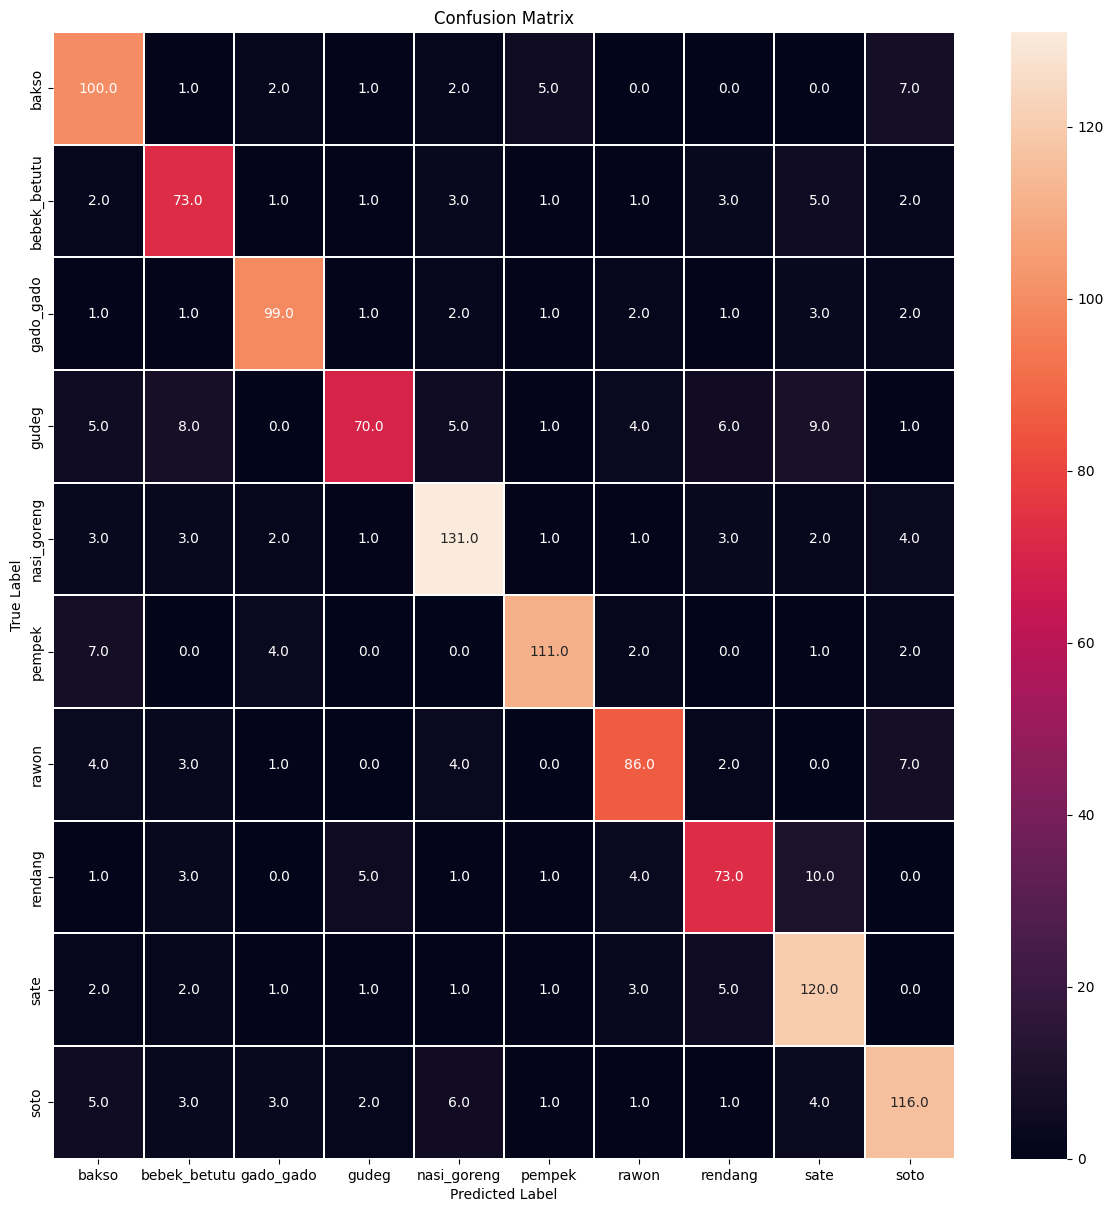

In [6]:
y_val = test_data.classes
y_pred = densemodel.predict(test_data)
y_pred = np.argmax(y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, y_val)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True,
            linewidths=0.01,
            linecolor="white",
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket")

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_data.class_indices)
ax.yaxis.set_ticklabels(test_data.class_indices)
f.tight_layout()
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_pred, y_val)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_pred, y_val, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_pred, y_val, average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_pred, y_val, average='macro')
print('F1 score: %f' % f1)

Accuracy: 0.820620
Precision: 0.820461
Recall: 0.814870
F1 score: 0.815519
